# Preamble

In [6]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_grph
import pet_cli.parametric_images as pet_pim
import nibabel
import json
import os
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# Using Noise Free TACs

## Loading In TAC Parameters

In [7]:
def count_parameter_sets(model_directories: dict) -> dict:
    model_nums = {}
    for model, directory in model_directories.items():
        model_nums[model] = len([f for f in os.listdir(directory) if os.path.splitext(f)[1] == '.json'])
    return model_nums

In [8]:
DIR_PRE = "../../"
model_dirs = {"1tcm":f"{DIR_PRE}data/tcm_tacs/1tcm/",
              "serial_2tcm_k4zero":f"{DIR_PRE}data/tcm_tacs/serial_2tcm_k4zero/",
              "serial_2tcm":f"{DIR_PRE}data/tcm_tacs/serial_2tcm/"}

In [9]:
MODELS_NUMS = count_parameter_sets(model_dirs)
MODELS_NUMS

{'1tcm': 2, 'serial_2tcm_k4zero': 2, 'serial_2tcm': 3}

In [11]:
def safe_load_json(file_path):
    try:
        with open(file_path) as file:
            return json.load(file)
    except Exception as e:
        print(f"Couldn't read file {file_path}. Error: {e}")
        return None

In [12]:
model_params = {
    model: {f'set-{i:02}': safe_load_json(f'{DIR_PRE}data/tcm_tacs/{model}/params_{model}_set-{i:02}.json') for i in
            range(num)} for model, num in MODELS_NUMS.items()}

## Loading In TACs

In [13]:
def safe_load_tac(filename):
    try:
        return np.array(np.loadtxt(filename).T, dtype=float, order='C')
    except Exception as e:
        print(f"Couldn't read file {filename}. Error: {e}")
        return None

In [17]:
pTAC = safe_load_tac('../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt')

In [14]:
all_tacs = {}
all_tacs['noise-free'] = {a_model: {f'set-{i:02}': safe_load_tac(
    f'{DIR_PRE}data/tcm_tacs/{a_model}/noise_free/tac_{("_".join(a_model.split("_")[1:]) if "serial_2tcm" in a_model else a_model)}_set-{i:02}.txt')
    for i in range(num)} for a_model, num in MODELS_NUMS.items()}
all_tacs['gaussian-noise'] = {a_model: {f'set-{i:02}': safe_load_tac(
    f'{DIR_PRE}data/tcm_tacs/{a_model}/gaussian_noise/tac_{("_".join(a_model.split("_")[1:]) if "serial_2tcm" in a_model else a_model)}_set-{i:02}.txt')
    for i in range(num)} for a_model, num in MODELS_NUMS.items()}

## Patlak Plots

In [41]:
from cycler import cycler

In [132]:
dar_cycler = cycler(color=['red', 'blue', 'green', 'yellow', 'purple', 'cyan', 'magenta'])
plt.rc('axes', prop_cycle=dar_cycler)

In [19]:
def gen_patlak_plot(pTAC: np.ndarray[float, float], tTAC: np.ndarray[float, float]):
    x = pet_grph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
    y = tTAC[1]/pTAC[1]
    return np.array([x, y])

In [21]:
patlak_xLab = r"$\frac{\int_{0}^{t}C_\mathrm{P}(s)\mathrm{d}s}{C_\mathrm{P}(t)}$"
patlak_yLab = r"$\frac{R(t)}{C_\mathrm{P}(t)}$"

In [22]:
def params_dict_to_label(params):
    tmp = []
    for p, val in params.items():
        tmp.append(f"$k_{{{p[1:]}}}={float(val):<.2f}$")
    return "; ".join(tmp)
params_dict_to_label(model_params['1tcm']['set-00']['params'])

'$k_{1}=1.00$; $k_{2}=0.25$'

In [136]:
patlak_plot_kwargs = {'lw':1, 'alpha':0.9, 'ms':8, 'marker':'.'}

def calc_patlak_x_and_y(pTAC, tTAC):
    good_points = np.argwhere(pTAC[1] != 0.0).T[0]
    xAr = pet_grph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1])[good_points] / pTAC[1][good_points]
    yAr = tTAC[1][good_points] / pTAC[1][good_points]
    return xAr, yAr
    
def add_linear_patlak_plot(pTAC, tTAC, axObj = None):
    if axObj is None:
        axObj = plt.gca()
    
    xAr, yAr = calc_patlak_x_and_y(pTAC=pTAC, tTAC=tTAC)
    
    axObj.plot(xAr, yAr, '-', **patlak_plot_kwargs)
    
    return None

def add_patlak_plot_shading(pTAC, tTAC, t_thresh_in_mins, axObj = None):
    if axObj is None:
        axObj = plt.gca()
    good_points = np.argwhere(pTAC[1] != 0.0).T[0]
    t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=pTAC[0][good_points], 
                                                 t_thresh_in_minutes=t_thresh_in_mins)
    
    xAr, yAr = calc_patlak_x_and_y(pTAC=pTAC, tTAC=tTAC)
    
    axObj.axvspan(xAr[t_thresh], xAr[-1], color='gray', alpha=0.2, zorder=0)
    return None

def add_patlak_fit_points(pTAC, tTAC, t_thresh_in_mins, axObj = None):
    if axObj is None:
        axObj = plt.gca()
    good_points = np.argwhere(pTAC[1] != 0.0).T[0]
    t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=pTAC[0][good_points], 
                                                 t_thresh_in_minutes=t_thresh_in_mins)
    
    xAr, yAr = calc_patlak_x_and_y(pTAC=pTAC, tTAC=tTAC)
    
    
    
    axObj.plot(xAr[t_thresh:], yAr[t_thresh:], 'o-', alpha=0.9, ms='5')
    return None

def add_patlak

### Example Plots

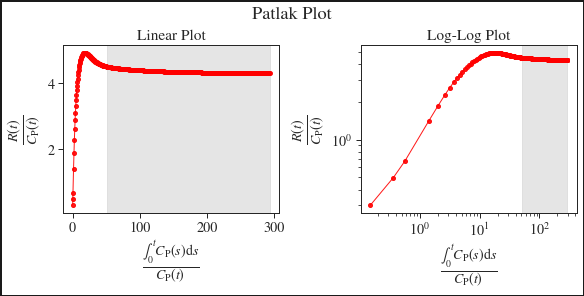

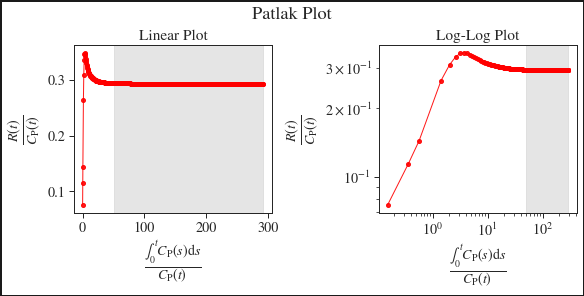

In [137]:
for a_model, num in MODELS_NUMS.items():
    
    for i in range(num):
        myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=72, linewidth=3.0, edgecolor='k')
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['noise-free'][a_model][f"set-{i:02}"]
        
        for axId, anAx in enumerate(myAx.flatten()):
            add_linear_patlak_plot(pTAC=pTAC, tTAC=_tTAC, axObj=anAx)
            add_patlak_plot_shading(pTAC=pTAC, tTAC=_tTAC, t_thresh_in_mins=30.0, axObj=anAx)
            add_patlak_line(pTAC=pTAC, tTAC=_tTAC, axObj=anAx)
#             add_patlak_fit_points(pTAC=pTAC, tTAC=_tTAC, t_thresh_in_mins=30.0, axObj=anAx)
    
        myAx[0].set(title=f"Linear Plot")
        myAx[1].set(title=f"Log-Log Plot", xscale='log', yscale='log')
        myAx[0].set_xlabel(patlak_xLab, fontsize=20)
        myAx[0].set_ylabel(patlak_yLab, fontsize=20)
        myAx[1].set_xlabel(patlak_xLab, fontsize=20)
        myAx[1].set_ylabel(patlak_yLab, fontsize=20)
        myFig.suptitle(f"Patlak Plot")
        #     myFig.legend(bbox_to_anchor=(1.0, 0.6), loc='center left', title='Parameters')
        plt.show()
    break

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_19251/1441528903.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_grph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_19251/1441528903.py:3: RuntimeWarning: invalid value encountered in divide
  y = tTAC[1]/pTAC[1]


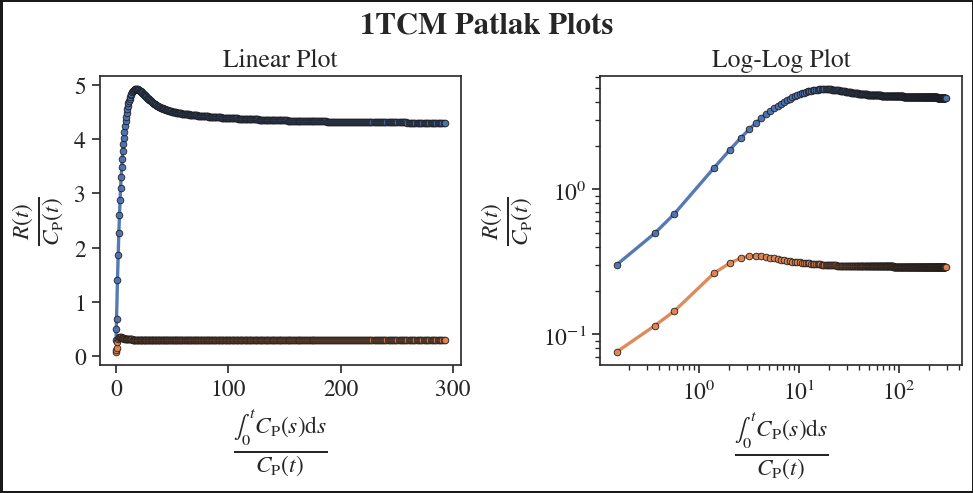

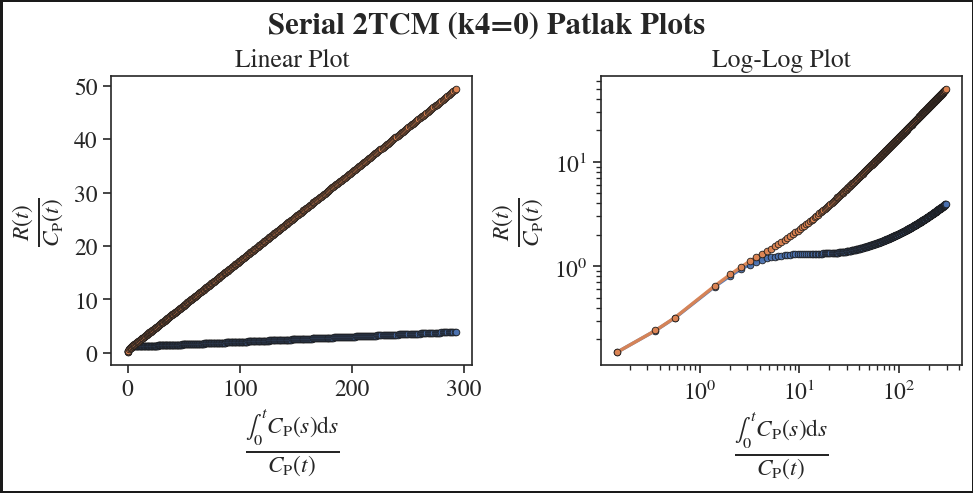

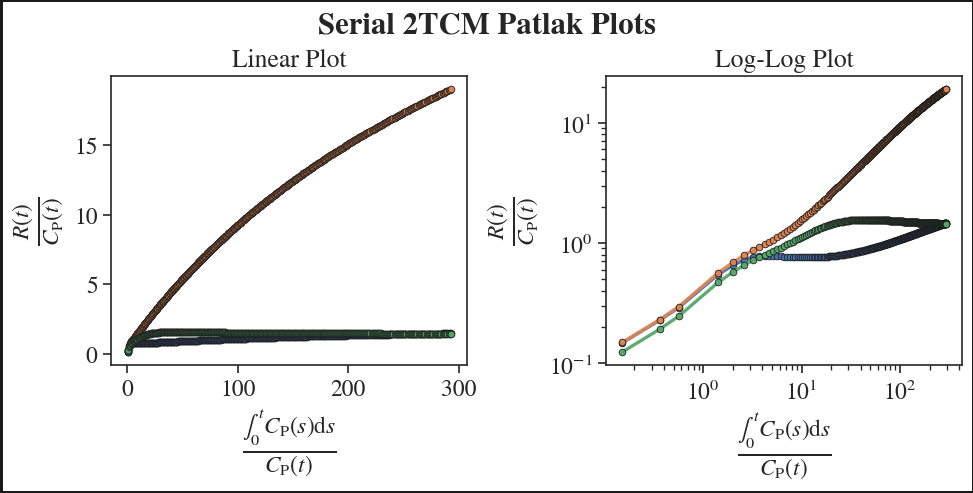

In [25]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=120, linewidth=3.0, edgecolor='k')
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['noise-free'][a_model][f"set-{i:02}"]
        patlak_vars = gen_patlak_plot(pTAC, _tTAC)
        
        myAx[0].plot(*patlak_vars, '.-', alpha=0.95, lw=2, 
                     #label=params_dict_to_label(_params['params']), 
                     color=f"C{i}",
                     ms=8, mec='k', mew=0.5)
        myAx[1].plot(*patlak_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)
    
    myAx[0].set(title=f"Linear Plot")
    myAx[1].set(title=f"Log-Log Plot", xscale='log', yscale='log')
    myAx[0].set_xlabel(patlak_xLab, fontsize=20)
    myAx[0].set_ylabel(patlak_yLab, fontsize=20)
    myAx[1].set_xlabel(patlak_xLab, fontsize=20)
    myAx[1].set_ylabel(patlak_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']} Patlak Plots", fontweight='bold')
#     myFig.legend(bbox_to_anchor=(1.0, 0.6), loc='center left', title='Parameters')
    plt.show()

## Logan Plots

In [ ]:
def gen_logan_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / tTAC[1]
    y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / tTAC[1]
    return np.array([x, y])

def gen_alt_logan_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
    y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / pTAC[1]
    return np.array([x, y])
    